# Multipoint ICME lineups in the Solar Orbiter era

Notebook for the results and plots shown in the paper Möstl et al. 2021 ApJ (in prep.).

https://github.com/helioforecast/Papers/tree/master/Moestl2021_multipoint


Authors: C. Möstl, IWF Graz, Austria https://twitter.com/chrisoutofspace 

**work in progress, last update August 2021**

To install a conda environment, dependencies are listed under environment.yml, and pip in requirements.txt. Plots are saved in folder "plots" as png and pdf. 


---

**Data sources**

The ICME catalog ICMECATv2.0 (updated 2021 Apr 29) is included in this repository in folder "data". The latest versions can be downloaded from https://doi.org/10.6084/m9.figshare.6356420 or https://helioforecast.space/icmecat

The CME arrival catalog (based on STEREO heliospheric imager observations) ARRCATv2.0 (updated 2021-Apr-23) is included in the folder "data". Latest versions can be obtained from either: https://helioforecast.space/arrcat or https://doi.org/10.6084/m9.figshare.12271292 

If needed, in situ data needs to be downloaded into a directory defined in config.py from this figshare repository: https://doi.org/10.6084/m9.figshare.11973693.v10


---
TO DO:

---

**MIT LICENSE**

Copyright 2021, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.





In [4]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import seaborn as sns
import numpy as np
import scipy.io
from scipy import stats
import sys
from datetime import timedelta
import time
import pickle
import os
import copy
import urllib
import json
import warnings
import importlib

import sunpy.time
from sunpy.time import parse_time

import heliopy.spice as spice
import heliopy.data.spice as spicedata

import astropy
import astropy.constants as const

#our own packages
import py3dcore
import heliosat

#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path

#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script cme_sig.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='plots'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

plt.rcParams["figure.figsize"] = (15,8)
plt.close('all')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3

print('done')

done


In [5]:
########### load ICMECAT v2.0, made with icmecat.py or ipynb
file='icmecat/HELCATS_ICMECAT_v20_pandas.p'
print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

[ic,h,p]=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()


loaded  icmecat/HELCATS_ICMECAT_v20_pandas.p

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')



In [6]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_MOESTL_20210619_01,STEREO-A,2021-06-19 20:44:00,2021-06-20 01:30:00,2021-06-21 06:29:00,0.9615,-48.30,-4.21,33.75,11.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_STEREO_A_MOESTL_20210526_01,STEREO-A,2021-05-26 06:11:00,2021-05-26 06:11:00,2021-05-27 22:25:00,0.9639,-50.64,-6.42,40.23,17.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_BEPI_MOESTL_20210525_01,BepiColombo,2021-05-25 00:27:00,2021-05-25 00:27:00,2021-05-26 04:42:00,0.7882,-111.90,-3.24,28.25,15.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ICME_Wind_MOESTL_20210512_01,Wind,2021-05-12 05:54:00,2021-05-12 14:44:00,2021-05-13 13:38:00,1.0018,-0.08,-2.99,31.73,23.2,...,4.5,2.8,187458.8,92667.1,444.1,15.8,19.8,11.6,6.5,3.8
4,ICME_BEPI_MOESTL_20210508_01,BepiColombo,2021-05-08 18:34:00,2021-05-09 02:24:00,2021-05-10 00:22:00,0.7313,-118.32,-2.24,29.80,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,ICME_VEX_SGOOD_20070213_01,VEX,2007-02-13 14:40:00,2007-02-13 14:40:00,2007-02-14 09:33:00,0.7245,-117.25,2.83,18.88,19.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,ICME_Wind_NASA_20070115_01,Wind,2007-01-15 20:49:00,2007-01-15 20:49:00,2007-01-16 04:45:00,0.9731,0.15,-4.57,7.93,10.4,...,4.1,1.4,97358.1,37602.1,NaN,NaN,NaN,NaN,NaN,NaN
805,ICME_STEREO_B_JIAN_20070114_01,STEREO-B,2007-01-14 12:24:00,2007-01-14 13:59:00,2007-01-15 07:37:00,0.9791,0.02,-4.52,19.22,14.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
806,ICME_STEREO_A_JIAN_20070114_01,STEREO-A,2007-01-14 12:11:00,2007-01-14 14:39:00,2007-01-15 07:34:00,0.9727,0.26,-4.61,19.38,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#load HIGeoCAT
from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging 

#https://www.helcats-fp7.eu/
#LOAD HELCATS HIGeoCAT
url_higeocat='https://www.helcats-fp7.eu/catalogues/data/HCME_WP3_V06.vot'

try: urllib.request.urlretrieve(url_higeocat,'data/HCME_WP3_V06.vot')
except urllib.error.URLError as e:
    print('higeocat not loaded')

higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    
higeocat_t0=parse_time(higeocat['SSE Launch']).datetime   #backprojected launch time

sse_speed=higeocat['SSE Speed']
sse_lon=higeocat['SSE HEEQ Long']
sse_lat=higeocat['SSE HEEQ Lat']
higeocat_name=np.array(higeocat['SC'].astype(str))



print('done')

done


## Lineup catalog

## HI - in situ connection catalog


In [ ]:
## 1 load data

### 1.1. load in situ data

In [23]:
#set to > 0 for loading
load_data=0

if load_data > 0:
    
    print('load data (takes a minute or so)')
    print('')

    
    ################## Spacecraft
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    print('load and merge Wind data HEEQ') 
    #from HELCATS HEEQ until 2018 1 1 + new self-processed data with heliosat and hd.save_wind_data
    filewin="wind_2007_2018_heeq_helcats.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  
    
    #or use: filewin2="wind_2018_now_heeq.p" 
    filewin2="wind_2018_2019_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #merge Wind old and new data 
    #cut off HELCATS data at end of 2017, win2 begins exactly after this
    win1=win1[np.where(win1.time < parse_time('2018-Jan-01 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))

    print('Wind merging done')
    

    filevex='vex_2007_2014_sceq_removed.p'
    [vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )
    
    filevex='vex_2007_2014_sceq.p'
    [vexnon,hvexnon]=pickle.load(open(data_path+filevex, 'rb' ) )
    

    filemes='messenger_2007_2015_sceq_removed.p'
    [mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )

    filemes='messenger_2007_2015_sceq.p'
    [mesnon,hmesnon]=pickle.load(open(data_path+filemes, 'rb' ) )

 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
             
    filesta='stereoa_2007_2019_sceq.p'
    [sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

    filepsp='psp_2018_2019_sceq.p'
    [psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) )  
    
    fileuly='ulysses_1990_2009_rtn.p'
    [uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) ) 
    
    fileomni='omni_1963_2020.p'
    [omni,homni]=pickle.load(open(data_path+fileomni, "rb" ) ) 

    print('load all data done') 

### 1.2 get ICME catalog

In [40]:
#if needed, directly load latest version from helio4cast website:
#url='https://helioforecast.space/static/sync/icmecat/HELCATS_ICMECAT_v20.csv'
#ic=pd.read_csv(url)
#ic=ic.drop(columns='Unnamed: 0') #drop an extra index column

#or from figshare: https://doi.org/10.6084/m9.figshare.6356420, here version 6 is used from 2021 Apr 29

#load ICMECAT
[ic,header,parameters] = pickle.load(open('data/HELCATS_ICMECAT_v20_pandas.p', "rb" ))

print('Keys (parameters) in this pandas data frame are:')
print(ic.keys())
print()

################### get indices of events for each spacecraft

mercury_orbit_insertion_time= parse_time('2011-03-18').datetime

#spacecraft near the 4 terrestrial planets
#get indices for Mercury after orbit insertion in March 2011
merci=np.where(np.logical_and(ic.sc_insitu =='MESSENGER', parse_time(ic.icme_start_time).datetime > mercury_orbit_insertion_time))[0]
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    

#other spacecraft
#all MESSENGER events including cruise phase
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
pspi=np.where(ic.sc_insitu == 'ParkerSolarProbe')[:][0]    
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]   

ic

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')



,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_Wind_MOESTL_20210311_01,Wind,2021-03-11 21:40:00,2021-03-11 21:40:00,2021-03-12 09:26:00,0.9838,0.24,-7.28,11.77,9.5,...,4.2,0.2,13010.2,4965.5,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_SOLO_MOESTL_20201119_01,SolarOrbiter,2020-12-19 20:39:00,2020-12-20 10:15:00,2020-12-21 04:30:00,0.7682,125.87,-3.05,31.85,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_STEREO_A_MOESTL_20201203_01,STEREO-A,2020-12-03 18:04:00,2020-12-03 22:19:00,2020-12-04 02:14:00,0.9596,-57.48,6.41,8.17,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ICME_STEREO_A_MOESTL_20201201_01,STEREO-A,2020-12-01 07:28:00,2020-12-01 10:17:00,2020-12-01 18:30:00,0.9594,-57.60,6.57,11.03,15.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_PSP_MOESTL_20201201_01,PSP,2020-12-01 02:22:00,2020-12-01 03:13:00,2020-12-01 08:34:00,0.8037,-96.85,3.77,6.20,49.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,ICME_VEX_SGOOD_20070213_01,VEX,2007-02-13 14:40:00,2007-02-13 14:40:00,2007-02-14 09:33:00,0.7245,-117.25,2.83,18.88,19.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
774,ICME_Wind_NASA_20070115_01,Wind,2007-01-15 20:49:00,2007-01-15 20:49:00,2007-01-16 04:45:00,0.9731,0.15,-4.57,7.93,10.4,...,4.1,1.4,97358.1,37602.1,NaN,NaN,NaN,NaN,NaN,NaN
775,ICME_STEREO_B_JIAN_20070114_01,STEREO-B,2007-01-14 12:24:00,2007-01-14 13:59:00,2007-01-15 07:37:00,0.9791,0.02,-4.52,19.22,14.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776,ICME_STEREO_A_JIAN_20070114_01,STEREO-A,2007-01-14 12:11:00,2007-01-14 14:39:00,2007-01-15 07:34:00,0.9727,0.26,-4.61,19.38,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 get CME arrival catalog

In [45]:
#load arrcat as pandas dataframe
file='data/HELCATS_ARRCAT_v20_pandas.p'
[ac,h]=pickle.load( open(file, 'rb'))   
ac

,id,sc,target_name,sse_launch_time,target_arrival_time,target_arrival_time_err,target_distance,target_heeq_lon,target_heeq_lat,target_delta,sse_heeq_lon,sse_heeq_lat,sse_speed,sse_speed_err,target_speed,target_speed_err,pa_fit,pa_n,pa_s,pa_center
0,HCME_A__20210331_01,A,Earth_L1,2021-03-30 14:29,2021-04-05 17:54,12.7,0.991,0.00,-6.27,28.0,-28,1,397,34,279,24,285,250,305,277.5
1,HCME_A__20210331_01,A,STEREO-A,2021-03-30 14:29,2021-04-05 05:42,11.7,0.967,-54.44,-6.72,-26.4,-28,1,397,34,297,25,285,250,305,277.5
2,HCME_A__20210322_01,A,Earth_L1,2021-03-22 00:36,2021-03-26 23:12,1.7,0.988,-0.00,-6.79,8.0,-8,7,353,5,346,5,285,260,310,285.0
3,HCME_A__20210320_01,A,Earth_L1,2021-03-20 02:12,2021-03-24 11:25,1.6,0.987,-0.00,-6.90,21.0,-21,0,456,7,390,6,280,215,330,272.5
4,HCME_A__20210308_01,A,Earth_L1,2021-03-08 07:53,2021-03-13 09:49,1.7,0.984,0.00,-7.20,12.0,-12,-3,351,5,335,5,270,240,315,277.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,HCME_A__20070518_01,A,Venus,2007-05-17 20:34,2007-05-20 09:17,0.3,0.720,-57.25,-3.69,20.7,-78,-20,574,3,493,3,110,95,115,105.0
1627,HCME_A__20070518_01,A,Mercury,2007-05-17 20:34,2007-05-19 01:13,0.1,0.337,-99.24,0.56,-21.2,-78,-20,574,3,489,3,110,95,115,105.0
1628,HCME_A__20070516_01,A,Venus,2007-05-15 16:24,2007-05-18 23:10,0.2,0.720,-58.20,-3.74,-5.2,-53,16,383,1,380,1,70,30,120,75.0
1629,HCME_A__20070509_01,A,Mercury,2007-05-09 06:13,2007-05-10 07:53,2.8,0.308,-142.21,2.96,-0.2,-142,2,499,54,499,54,90,50,125,87.5


## 2 Basic 3DCORE modeling

### 2.1 Define 3DCORE functions

In [46]:
def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    ax.set_zlim([-view_radius, view_radius])
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)

    
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = model_obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    
    
def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
def plot_circle(ax,dist,**kwargs):        

    thetac = np.linspace(0, 2 * np.pi, 100)
    xc=dist*np.sin(thetac)
    yc=dist*np.cos(thetac)
    zc=0
    ax.plot(xc,yc,zc,ls='--',color='black',lw=0.3,**kwargs)
      

def plot_satellite(ax,satpos1,**kwargs):

    xc=satpos1[0]*np.cos(np.radians(satpos1[1]))
    yc=satpos1[0]*np.sin(np.radians(satpos1[1]))
    zc=0
    #print(xc,yc,zc)
    ax.scatter3D(xc,yc,zc,**kwargs)

### 2.2 Model settings

In [47]:
t_launch = datetime.datetime(2020, 1, 1, 0)

iparams_arr = np.array([[
    0,      # time offset
    0,    # l_1 (logitude) HEEQ
    0,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    5,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    600,    # v_0 (initial velocty in)
    -4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    20,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=1)
tm1 =  t_launch + datetime.timedelta(days=3.5)
tm2 =  t_launch + datetime.timedelta(days=5.0)


#colors for 3dplots

c0 = 'mediumseagreen'
c1 = "xkcd:red"
c2 = "xkcd:blue"


#colors for components in plots
cbt = "xkcd:black"
cbx = "xkcd:magenta"
cby = "xkcd:orange"
cbz = "xkcd:azure"

### 2.3 Define satellite positions *** to do HCI

In [48]:
############# define synthetic satellite positions - semi-circle at 1 AU, from -90 to +90 longitude

lonstart=-90
lonstep=5
lonend=90

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=1.0
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

print(satpos.r, satpos.lon)    

#another satpos definition for a semi circle at 0.5 AU
satpos2=copy.deepcopy(satpos)
satpos2.r=0.5

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-90. -85. -80. -75. -70. -65. -60. -55. -50. -45. -40. -35. -30. -25.
 -20. -15. -10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.
  50.  55.  60.  65.  70.  75.  80.  85.  90.]


### 2.4 Figure 1 model setup Nr.1 for illustration

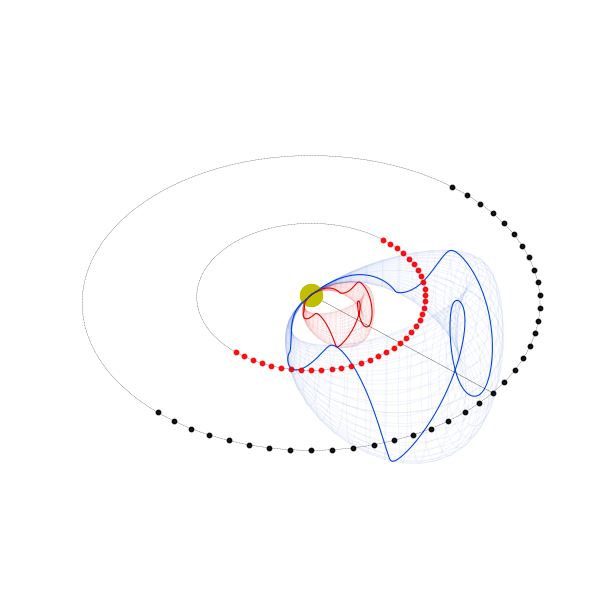

In [49]:
#use either 
#%matplotlib 
#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#%matplotlib inline


sns.set_context("talk")     
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=70)
ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=-50, view_elev=40, view_radius=0.8)
#in other planes
#plot_configure(ax, view_azim=0, view_elev=90, view_radius=0.7)
#plot_configure(ax, view_azim=0, view_elev=0, view_radius=0.6)


########## 3dcore plots
plot_3dcore(ax, model_obj, tm0, color=c1)
plot_3dcore_field(ax, model_obj, color=c1, step_size=0.005, lw=1.1, ls="-",q0=np.array([1, .1, np.pi/2]))

plot_3dcore(ax, model_obj, tm1, color=c2)
plot_3dcore_field(ax, model_obj, color=c2, step_size=0.005, lw=1.1, ls="-")

############# satellite plots
#plot_traj(ax, "Earth", tm1, frame="HEEQ", color=c1)
  
    
for i in np.arange(0,len(satpos)):
    plot_satellite(ax,satpos[i],color='black',alpha=0.9)    
    plot_satellite(ax,satpos2[i],color='red',alpha=0.9)


##########cosmetics
#approximate Sun Earth line
ax.plot([0,1],[0,0],[0,0],ls='-',color='black',lw=0.3)

plot_circle(ax,0.5)
plot_circle(ax,1.0)

#plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
#plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

plt.tight_layout()

plt.savefig('plots/fig1_setup.pdf')
plt.savefig('plots/fig1_setup.png', dpi=100)

### 2.5 Figure 2: Measure components for simple case

In [50]:
def measure(obj, satpos1, t0, t1, frame="HEEQ", bframe="HEE", satparams=None):
    
    #print(obj)
    print('input')
    print(t0,' / ', t1, frame, bframe)
    
    #if satparams:
    #    inst = getattr(heliosat, sat)(satparams)
    #else:
    #    inst = getattr(heliosat, sat)()        
    #print(inst)    
    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]    
    #position of spacecraft
    #o_s = inst.trajectory(t_s, frame=frame)
    
    #time resolution in hours
    res_in_days=1/24.    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    print('data points',len(t_s))
    
    #generate position from satpos - always constant
    o_s=np.zeros([len(t_s),3])
    o_s[:,0]=satpos1[0]   #R in AU 
    o_s[:,1]=np.radians(satpos1[1]) #longitude
    o_s[:,2]=np.radians(satpos1[2]) #latitude

    #print(t_s)
    #print(o_s)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b, o_s



current satpos measured is  20
input
2020-01-01 12:00:00  /  2020-01-19 12:00:00 HEEQ HEE
data points 432
took  0.061   seconds



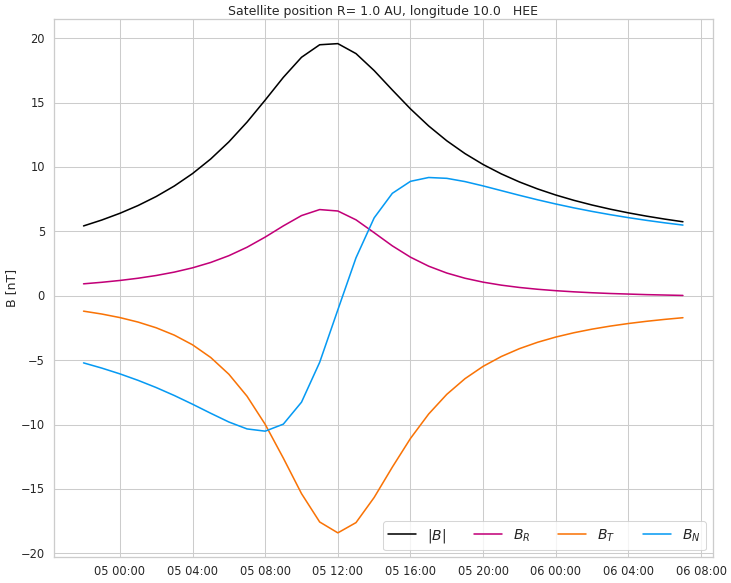

In [51]:
'''
t_launch = datetime.datetime(2020, 1, 1, 0)

iparams_arr = np.array([[
    0,      # time offset
    0,    # l_1 (logitude) HEEQ
    0,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    5,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    500,    # v_0 (initial velocty in)
    -1.0,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    15,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)

'''
############################### measure magnetic field
print()
start=time.time()

#18 is middle
satposindex=20
print('current satpos measured is ', satposindex)

#t0, btot0, bxyz0, os = measure(model_obj, satpos[6], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=20))
t1, btot1, bxyz1, os1 = measure(model_obj, satpos[satposindex], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=15))
#t2, btot2, bxyz2, os = measure(model_obj, satpos[30], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=20))
print('took ', np.round(time.time()-start,3), '  seconds')
print()
#print(t1)
#print(os1)


################################################
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(15, 12),dpi=50)

ax1 = fig.add_subplot(111)
ax1.set_title('Satellite position R= 1.0 AU, longitude '+str(satpos.lon[satposindex])+'   HEE')

ax1.plot(t1, btot1, color=cbt, label="$|B|$")
ax1.plot(t1, bxyz1[:, 0], color=cbx, label="$B_R$")
ax1.plot(t1, bxyz1[:, 1], color=cby, label="$B_T$")
ax1.plot(t1, bxyz1[:, 2], color=cbz, label="$B_N$")

ax1.legend(loc="lower right", fontsize=20,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %H:00'))
ax1.set_ylabel('B [nT]')
#plt.ylim(-1300,1300)
#plt.xlim(datetime.datetime(2022,6,1,23,0),datetime.datetime(2022,6,2,4,0))

plt.tight_layout()

plt.savefig('plots/fig2_measure_1.pdf', dpi=300)
plt.savefig('plots/fig2_measure_1.png', dpi=300)

## 3 Parameter analysis

what if we vary parameters - do we find any weird signatures?
vary orientation, speed, size, flattening
results: delta up, twist down -> same signature
back regions -> expansion, FR large, better for back region







In [ ]:
def plot_reconstruction(ax, obj, qs, **kwargs):

    ss = []

    for i in range(len(qs)):
        q = np.array([qs[i]])
        s = np.empty_like(q)

        obj.transform_qs(s, q)

        ss.append(s[0])

    ss = np.array(ss)

    ax.plot(*ss.T, **kwargs)

def reconstruct_path(obj, sat, t0, t1, frame="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    o_s = inst.trajectory(t_s, frame=frame)

    qs = []

    for i in range(len(t_s)):
        s = np.array([o_s[i]])
        q = np.empty_like(s)

        obj.propagate(t_s[i])
        obj.transform_sq(s, q)

        if q[0][0] < 1.0:
            qs.append(np.copy(q[0]))

    return qs

In [ ]:
QPATH_PSP = reconstruct_path(model_obj, "PSP", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000")
QPATH_PSP_FIXED = reconstruct_path(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000", satparams=TP_A)

In [ ]:
fig = plt.figure(figsize=(20, 20),dpi=50)
ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=80, view_elev=75, view_radius=.05)

plot_3dcore(ax, model_obj, TP_A, color=C0)
plot_3dcore_field(ax, model_obj, color=C0, steps=400, step_size=0.0005, lw=.5, ls=":")

plot_reconstruction(ax, model_obj, QPATH_PSP, color="c", ls="-", lw=2)
plot_reconstruction(ax, model_obj, QPATH_PSP_FIXED, color="m", ls="-", lw=2)

plt.tight_layout()

***

# 3 Parameter analysis - vary orientation, speed, size